# 文字と図形からなる標章の生成

- 全結合層５層
- 潜在空間の次元=10
- 画像サイズ=(256, 256)
- 学習データ数=500
- テストデータ数=50
- 学習エポック数=500

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [0]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.examples.tutorials.mnist import input_data

In [0]:
rng = np.random.RandomState(1234)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class Path:
  DPATH = 'drive/My Drive/Public/Data/20190225+2206/'

In [0]:
import os
import re

class MyImage:  
  @staticmethod
  def get_fnames(dpath):
    fnames = os.listdir(dpath)
    return fnames[:500]
  
  @staticmethod
  def escape_fnames(fnames):
    _fnames = []
    for fname in fnames:
      new_name = re.sub(r'\\', '\\\\', fname)
      _fnames.append(new_name)
     
    return _fnames
  
  @staticmethod
  def _get_images(dpath, fnames):
    imgs = []
    for i, fname in enumerate(fnames):
      print('Processing: {}/{}'.format(i+1, len(fnames)))
      if re.match(r'^.*\.JPG$', fname):
        imgs.append(Image.open(dpath + fname))
    
    return imgs
  
  @staticmethod
  def get_images(dpath):
    print('Getting fnames')
    fnames = MyImage.get_fnames(dpath)
    
    print('Escaping file names')
    fnames = MyImage.escape_fnames(fnames)
    
    print('Getting images')
    imgs = MyImage._get_images(dpath, fnames)
    
    return imgs    
    
  @staticmethod
  def preprocess(imgs, img_size=(256,256), img_format='L'):
    _imgs = []
    for img in imgs:
      img = img.convert(img_format)
      img = img.resize(img_size)
      _imgs.append(img)
     

    return _imgs

  @staticmethod
  def show_images(imgs):
    for img in imgs:
      plt.imshow(img)
      plt.show()

In [0]:
my_image = MyImage()

In [0]:
imgs = my_image.get_images(Path.DPATH)

Getting fnames
Escaping file names
Getting images
Processing: 1/500
Processing: 2/500
Processing: 3/500
Processing: 4/500
Processing: 5/500
Processing: 6/500
Processing: 7/500
Processing: 8/500
Processing: 9/500
Processing: 10/500
Processing: 11/500
Processing: 12/500
Processing: 13/500
Processing: 14/500
Processing: 15/500
Processing: 16/500
Processing: 17/500
Processing: 18/500
Processing: 19/500
Processing: 20/500
Processing: 21/500
Processing: 22/500
Processing: 23/500
Processing: 24/500
Processing: 25/500
Processing: 26/500
Processing: 27/500
Processing: 28/500
Processing: 29/500
Processing: 30/500
Processing: 31/500
Processing: 32/500
Processing: 33/500
Processing: 34/500
Processing: 35/500
Processing: 36/500
Processing: 37/500
Processing: 38/500
Processing: 39/500
Processing: 40/500
Processing: 41/500
Processing: 42/500
Processing: 43/500
Processing: 44/500
Processing: 45/500
Processing: 46/500
Processing: 47/500
Processing: 48/500
Processing: 49/500
Processing: 50/500
Processin

In [0]:
imgs = my_image.preprocess(imgs)

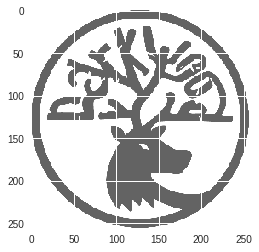

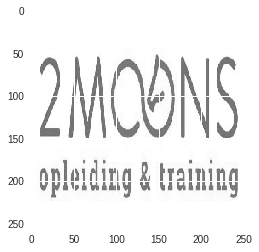

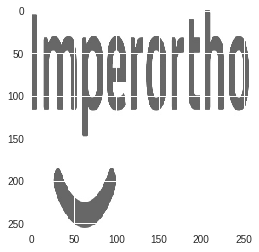

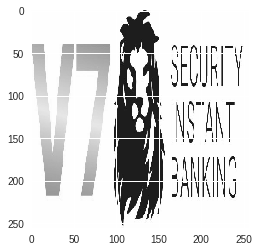

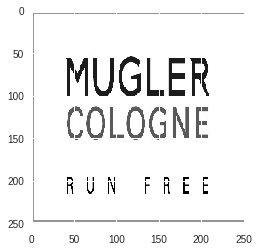

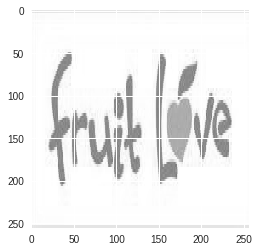

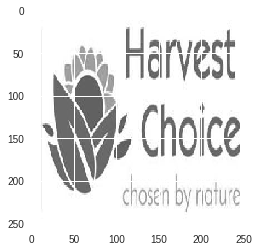

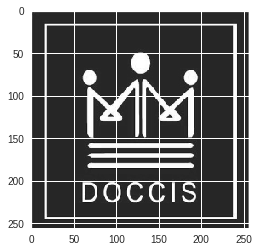

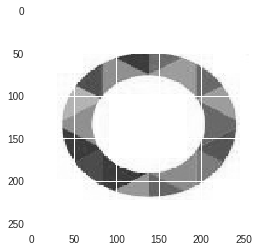

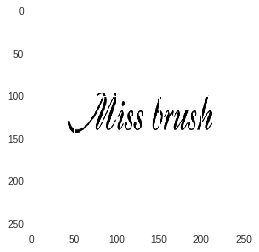

In [0]:
my_image.show_images(imgs[:10])

In [0]:
x_train = np.array(imgs[0]).reshape(256*256)
for img in imgs[1:-50]:
  x_train = np.vstack((x_train, np.array(img).reshape(256*256)))

In [0]:
x_valid = np.array(imgs[-50]).reshape(256*256)
for img in imgs[-51:]:
  x_valid = np.vstack((x_valid, np.array(img).reshape(256*256)))

In [0]:
x_train = (x_train / 255).astype(np.float32)
x_valid = (x_valid / 255).astype(np.float32)

In [0]:
tf.reset_default_graph()
z_dim = 10

def tf_log(x):
    return tf.log(tf.clip_by_value(x, 1e-10, x))

def encoder(x):
    with tf.variable_scope('Encoder', reuse=tf.AUTO_REUSE):
        h = tf.layers.Dense(units=512, activation=tf.nn.relu)(x)        
        h = tf.layers.Dense(units=1024, activation=tf.nn.relu)(h)        
        h = tf.layers.Dense(units=1024, activation=tf.nn.relu)(h)        
        h = tf.layers.Dense(units=32*32, activation=tf.nn.relu)(h)
        
        mean = tf.layers.Dense(units=z_dim)(h)
        var = tf.layers.Dense(units=z_dim, activation=tf.nn.softplus)(h)
    return mean, var

def sampling_z(mean, var):
    epsilon = tf.random_normal(shape=tf.shape(mean))
    z = mean + tf.sqrt(var) * epsilon
    return z

def decoder(z):
    with tf.variable_scope('Decoder', reuse=tf.AUTO_REUSE):
        h = tf.layers.Dense(units=512, activation=tf.nn.relu)(z)
        h = tf.layers.Dense(units=1024, activation=tf.nn.relu)(h)        
        h = tf.layers.Dense(units=1024, activation=tf.nn.relu)(h)        
        h = tf.layers.Dense(units=512, activation=tf.nn.relu)(h)         
        y = tf.layers.Dense(units=256*256, activation=tf.nn.sigmoid)(h)
    return y

def lower_bound(x):
    #Encode
    mean, var = encoder(x)
    KL = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + tf_log(var) - mean**2 - var, axis=1))
    
    #Z
    z = sampling_z(mean, var)
    
    #Decode
    y = decoder(z)
    reconstruction = tf.reduce_mean(tf.reduce_sum(x * tf_log(y) + (1 - x) * tf_log(1 - y), axis=1))
    
    lower_bound = [-KL, reconstruction]
    
    return lower_bound

In [0]:
x = tf.placeholder(tf.float32, [None, 256*256])
lower_bound = lower_bound(x)

cost = -tf.reduce_sum(lower_bound) # 下界を最大化するため、マイナスをとる
optimizer = tf.train.AdamOptimizer()
train = optimizer.minimize(cost)

valid = tf.reduce_sum(lower_bound)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
batch_size =100

n_batches = x_train.shape[0] // batch_size
n_epochs = 500

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for epoch in range(n_epochs):
    rng.shuffle(x_train)
    lower_bound_all = []
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        _, lowerbound = sess.run([train, lower_bound], feed_dict={x: x_train[start:end]})
        lower_bound_all.append(lowerbound)
    lower_bound_all = np.mean(lower_bound_all, axis=0)
    lower_bound_valid = sess.run(valid, feed_dict={x: x_valid[0:100]})
    print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
          (epoch+1, np.sum(lower_bound_all), lower_bound_all[0], lower_bound_all[1], lower_bound_valid))

EPOCH:1, Train Lower Bound:-53907.851562, (-8790.935547, -45116.914062), Valid Lower Bound:-34087.339844
EPOCH:2, Train Lower Bound:-31250.558594, (-1703.927979, -29546.630859), Valid Lower Bound:-33789.246094
EPOCH:3, Train Lower Bound:-29473.773438, (-948.573730, -28525.199219), Valid Lower Bound:-32914.175781
EPOCH:4, Train Lower Bound:-27727.320312, (-525.929443, -27201.390625), Valid Lower Bound:-32298.929688
EPOCH:5, Train Lower Bound:-26524.443359, (-310.833160, -26213.609375), Valid Lower Bound:-31150.738281
EPOCH:6, Train Lower Bound:-26206.398438, (-207.873474, -25998.525391), Valid Lower Bound:-30305.798828
EPOCH:7, Train Lower Bound:-26967.224609, (-170.033798, -26797.191406), Valid Lower Bound:-31017.529297
EPOCH:8, Train Lower Bound:-25461.583984, (-146.124496, -25315.458984), Valid Lower Bound:-30189.589844
EPOCH:9, Train Lower Bound:-26666.960938, (-189.034348, -26477.925781), Valid Lower Bound:-31785.632812
EPOCH:10, Train Lower Bound:-26664.724609, (-175.354797, -2648

In [0]:
x = tf.placeholder(tf.float32, [None, 256*256])
sample_z_func = encoder(x) # mean, var

In [0]:
z = tf.placeholder(tf.float32, [None, z_dim])
sample_x_func = decoder(z) # mean

In [0]:
def deprocess(x):
    _x = x.reshape(x.shape[0], 256, 256)
    return 1 - _x

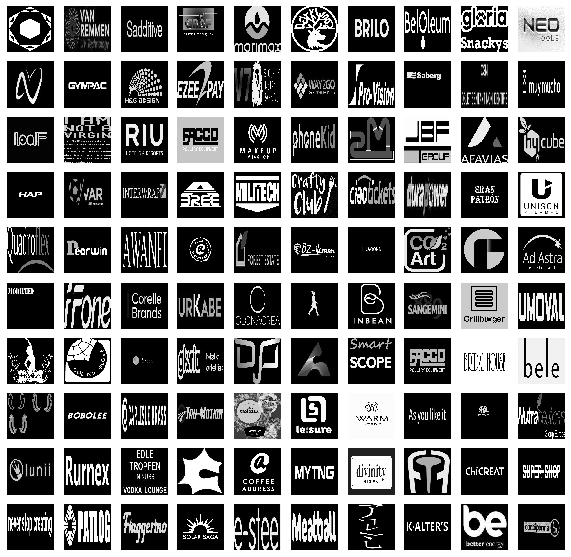

In [0]:
n_samples = 100

fig = plt.figure(figsize=(10, 10))

_sample_x = deprocess(x_train[:n_samples])

for j, _x in enumerate(_sample_x):
    ax = fig.add_subplot(10, 10, j+1, xticks=[], yticks=[])
    ax.imshow(_x, 'gray')

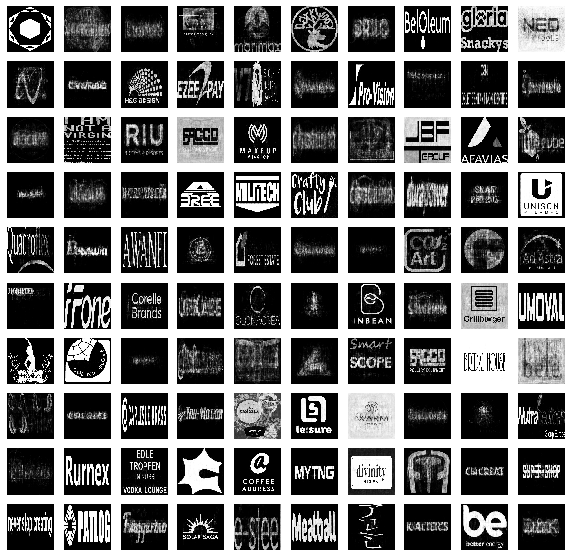

In [0]:
# Encode
mean, var = sess.run(sample_z_func, feed_dict={x: x_train[:n_samples]})
sample_z = mean

# Decode
sample_x = sess.run(sample_x_func, feed_dict={z: sample_z})

fig = plt.figure(figsize=(10, 10))

_sample_x = deprocess(sample_x)

for j, _x in enumerate(_sample_x):
    ax = fig.add_subplot(10, 10, j+1, xticks=[], yticks=[])
    ax.imshow(_x, 'gray')

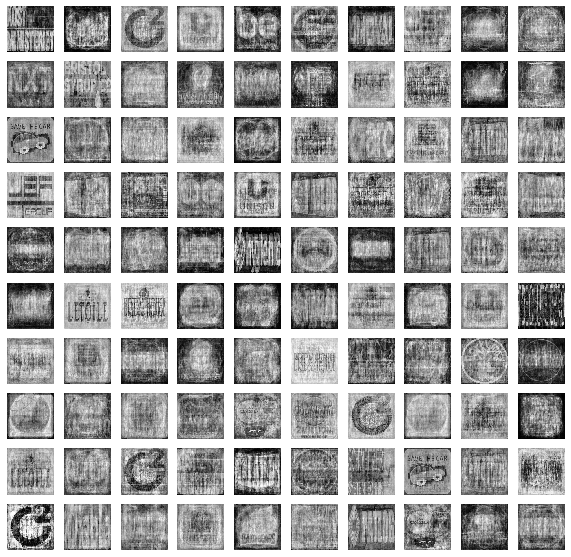

In [0]:
sample_z = np.random.standard_normal((n_samples, z_dim)).astype('float32')
sample_z = sess.run(sample_x_func, feed_dict={z: sample_z})

fig = plt.figure(figsize=(10, 10))

_sample_x = deprocess(sample_z)

for j, _x in enumerate(_sample_x):
    ax = fig.add_subplot(10, 10, j+1, xticks=[], yticks=[])
    ax.imshow(_x, 'gray')

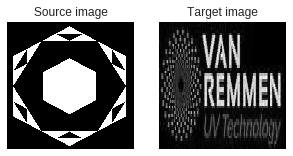

In [0]:
# Source
x_0 = x_train[:1]

# Target
x_1 = x_train[1:2]

fig = plt.figure(figsize=(5, 5))
ax_0 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax_0.set_title('Source image')
ax_0.imshow(deprocess(x_0)[0], 'gray')

ax_1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax_1.set_title('Target image')
ax_1.imshow(deprocess(x_1)[0], 'gray')

plt.show()

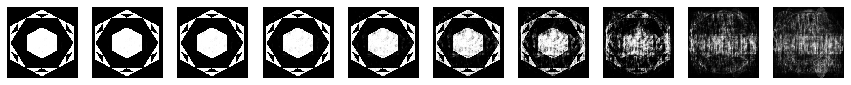

In [0]:
# 潜在空間に写像
sample_z_0, _ = sess.run(sample_z_func, feed_dict={x: x_0})
sample_z_1, _ = sess.run(sample_z_func, feed_dict={x: x_1})

move = sample_z_1 - sample_z_0

fig = plt.figure(figsize=(15, 15))

for i, j in enumerate(np.linspace(0, 1, 10)):
    # 線形補間
    _z = sample_z_0 + j*move
    sample_x = sess.run(sample_x_func, feed_dict={z: _z})

    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(deprocess(sample_x)[0], 'gray')